In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import entropy, gaussian_kde, spearmanr

GENDER_RATIO_DATAPATH = "results/gender_ratio.json"
FEATURE_MASK_DATAPATH = "results/feature_mask.json"

In [2]:
import json
from collections import defaultdict


def count_bias_analyses_per_masked_feature(results_path):
    """Counts the number of bias analyses performed for each masked feature."""
    with open(results_path, "r") as f:
        results = json.load(f)

    feature_counts = defaultdict(int)
    for experiment in results:
        masked_feature = experiment["metadata"]["masked_feature"]
        feature_counts[masked_feature] += len(experiment["bias_analyses"])

    return dict(feature_counts)


feature_counts = count_bias_analyses_per_masked_feature(FEATURE_MASK_DATAPATH)
feature_counts

{None: 6,
 'left_eye': 10,
 'right_eye': 10,
 'nose': 10,
 'lips': 10,
 'left_cheek': 10,
 'right_cheek': 10,
 'chin': 10,
 'forehead': 10,
 'left_eyebrow': 10,
 'right_eyebrow': 10}

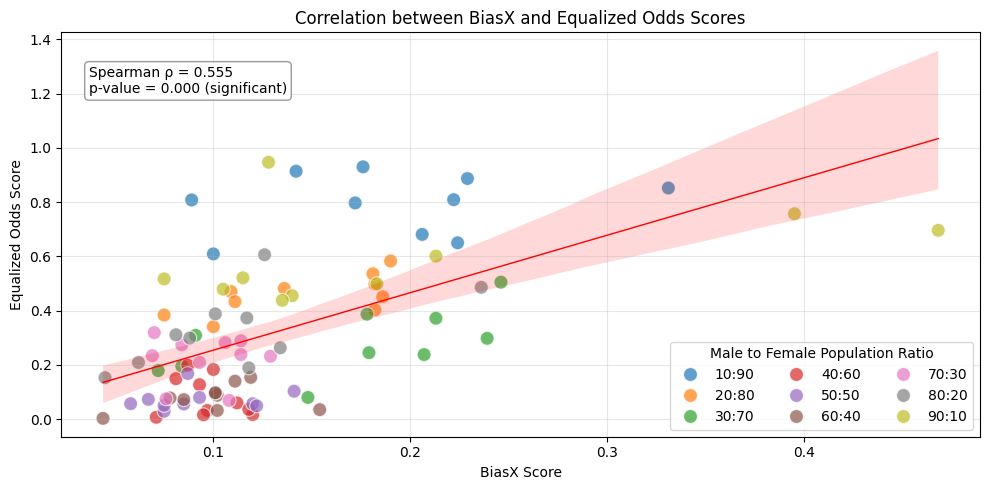

In [3]:
def plot_bias_correlation():
    """Visualizes Spearman correlation between BiasX and Equalized Odds metrics."""
    with open(GENDER_RATIO_DATAPATH, "r") as file:
        experiment_data = json.load(file)

    data_points = [
        {
            "ratio_label": f"{exp['metadata']['male_ratio']}:{exp['metadata']['female_ratio']}",
            "biasx": analysis["disparity_scores"]["biasx"],
            "equalized_odds": analysis["disparity_scores"]["equalized_odds"],
        }
        for exp in experiment_data
        for analysis in exp["bias_analyses"]
    ]
    data_points = sorted(data_points, key=lambda x: x["ratio_label"])

    df = pd.DataFrame(data_points)
    corr, p_value = spearmanr(df["biasx"], df["equalized_odds"])

    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=df, x="biasx", y="equalized_odds", hue="ratio_label", s=100, alpha=0.7)
    sns.regplot(x=df["biasx"], y=df["equalized_odds"], scatter=False, color="red", line_kws={"linewidth": 1}, ci=95)

    plt.title("Correlation between BiasX and Equalized Odds Scores")
    plt.xlabel("BiasX Score")
    plt.ylabel("Equalized Odds Score")

    significance = "significant" if p_value < 0.05 else "not significant"
    annotation = f"Spearman ρ = {corr:.3f}\np-value = {p_value:.3f} ({significance})"
    plt.annotate(annotation, xy=(0.03, 0.85), xycoords="axes fraction", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.legend(title="Male to Female Population Ratio", ncol=3)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_bias_correlation()

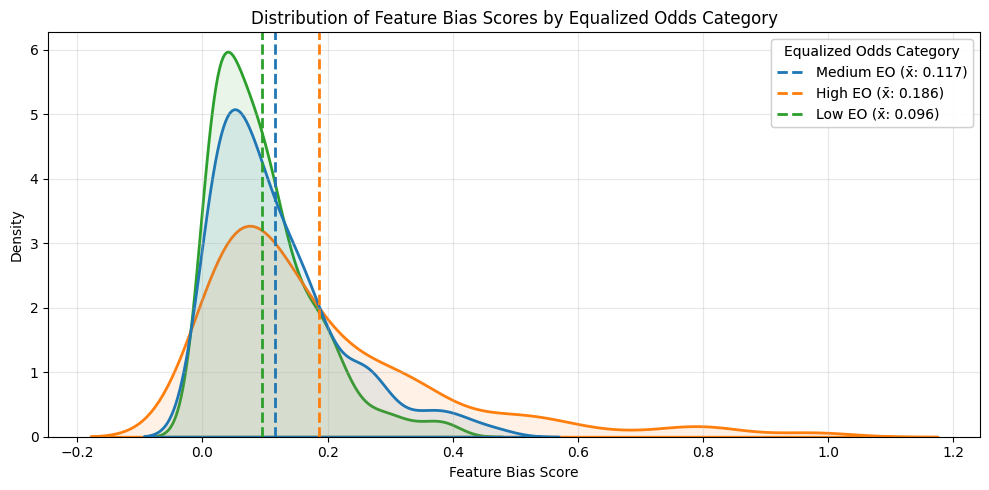

In [4]:
def plot_feature_bias_distribution():
    """Creates KDE plot for feature bias scores grouped by equalized odds categories."""
    with open(GENDER_RATIO_DATAPATH, "r") as file:
        experiment_data = json.load(file)

    data_points = [
        {
            "feature": feature,
            "bias_score": analysis_data["bias_score"],
            "equalized_odds": bias_analysis["disparity_scores"]["equalized_odds"],
        }
        for exp in experiment_data
        for bias_analysis in exp["bias_analyses"]
        for feature, analysis_data in bias_analysis["feature_analyses"].items()
    ]

    df = pd.DataFrame(data_points)

    low_threshold = df["equalized_odds"].quantile(0.33)
    high_threshold = df["equalized_odds"].quantile(0.66)

    df["eq_odds_category"] = df["equalized_odds"].apply(lambda score: "Low EO" if score <= low_threshold else "Medium EO" if score <= high_threshold else "High EO")

    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df, x="bias_score", hue="eq_odds_category", fill=True, common_norm=False, alpha=0.1, linewidth=2)

    categories = df["eq_odds_category"].unique()
    for category in categories:
        mean_bias = df[df["eq_odds_category"] == category]["bias_score"].mean()
        plt.axvline(x=mean_bias, color=sns.color_palette()[list(categories).index(category)], linestyle="--", linewidth=2, label=f"{category} (x̄: {mean_bias:.3f})")

    plt.title("Distribution of Feature Bias Scores by Equalized Odds Category")
    plt.xlabel("Feature Bias Score")
    plt.ylabel("Density")

    handles, labels = plt.gca().get_legend_handles_labels()
    first_legend = plt.legend(handles[: len(categories)], labels[: len(categories)], title="Equalized Odds Category")
    plt.gca().add_artist(first_legend)

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_feature_bias_distribution()

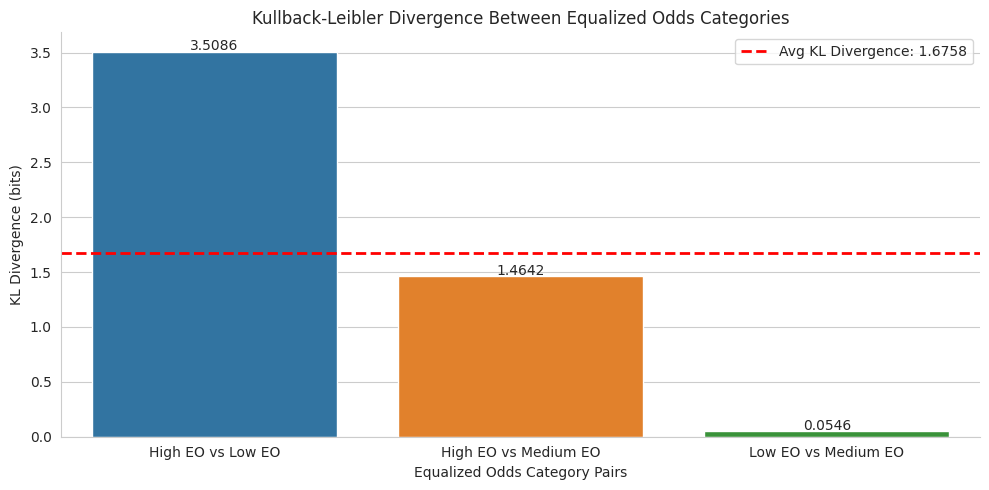

In [5]:
def calculate_symmetric_kl_divergence(categories, kde_functions, evaluation_points):
    """Computes symmetric KL divergence between distributions."""
    category_pairs = []
    kl_values = []

    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:
                p = kde_functions[cat1](evaluation_points)
                q = kde_functions[cat2](evaluation_points)

                p = p / np.sum(p)
                q = q / np.sum(q)

                symmetric_kl = (entropy(p, q) + entropy(q, p)) / 2

                category_pairs.append(f"{cat1} vs {cat2}")
                kl_values.append(symmetric_kl)

    return category_pairs, kl_values


def plot_kl_divergence():
    """Visualizes KL divergence between feature bias distributions across EO categories."""
    with open(GENDER_RATIO_DATAPATH, "r") as file:
        experiment_data = json.load(file)

    data_points = [
        {
            "feature": feature,
            "bias_score": data["bias_score"],
            "equalized_odds": analysis["disparity_scores"]["equalized_odds"],
        }
        for exp in experiment_data
        for analysis in exp["bias_analyses"]
        for feature, data in analysis["feature_analyses"].items()
    ]

    df = pd.DataFrame(data_points)

    thresholds = df["equalized_odds"].quantile([0.33, 0.66])
    df["eq_odds_category"] = pd.cut(
        df["equalized_odds"],
        bins=[0, thresholds.iloc[0], thresholds.iloc[1], 1],
        labels=["Low EO", "Medium EO", "High EO"],
    )

    categories = sorted(df["eq_odds_category"].unique())

    kde_functions = {category: gaussian_kde(df[df["eq_odds_category"] == category]["bias_score"].values) for category in categories}

    feature_ranges = {
        category: (
            max(0.001, df[df["eq_odds_category"] == category]["bias_score"].min() - 0.05),
            min(0.999, df[df["eq_odds_category"] == category]["bias_score"].max() + 0.05),
        )
        for category in categories
    }

    min_x = min(rang[0] for rang in feature_ranges.values())
    max_x = max(rang[1] for rang in feature_ranges.values())
    evaluation_points = np.linspace(min_x, max_x, 1000)

    category_pairs, kl_values = calculate_symmetric_kl_divergence(categories, kde_functions, evaluation_points)

    plt.figure(figsize=(10, 5))
    sns.set_style("whitegrid")

    ax = sns.barplot(x=category_pairs, y=kl_values, hue=category_pairs)

    avg_kl = np.mean(kl_values)
    plt.axhline(y=avg_kl, color="red", linestyle="--", linewidth=2, label=f"Avg KL Divergence: {avg_kl:.4f}")

    for i, kl_value in enumerate(kl_values):
        plt.text(i, kl_value + 0.01, f"{kl_value:.4f}", ha="center")

    plt.title("Kullback-Leibler Divergence Between Equalized Odds Categories")
    plt.xlabel("Equalized Odds Category Pairs")
    plt.ylabel("KL Divergence (bits)")
    plt.legend(loc="upper right")

    sns.despine()
    plt.tight_layout()
    plt.show()


plot_kl_divergence()

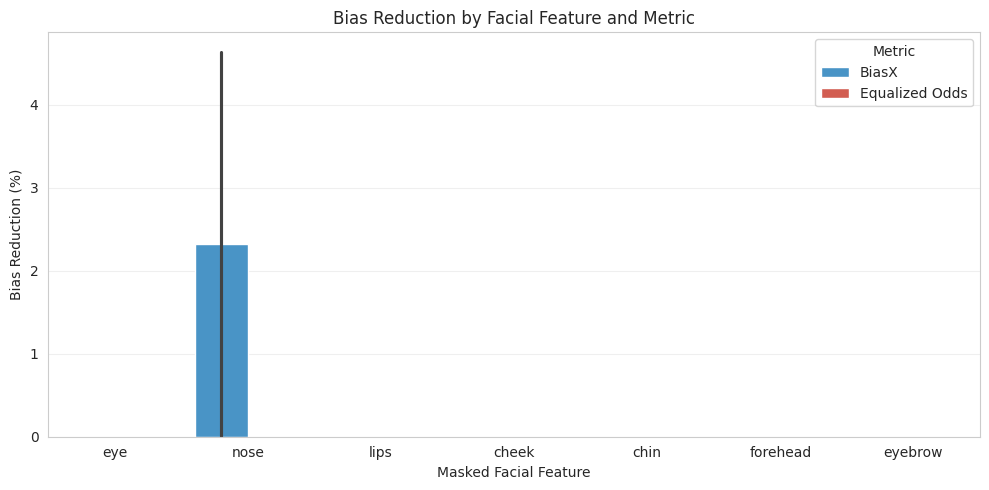

In [6]:
def prepare_ablation_data(experiment_results):
    """Prepares data for feature ablation visualization."""
    baseline_results = []
    masked_results = {}

    for exp in experiment_results:
        metadata = exp["metadata"]
        if metadata["male_ratio"] == 50 and metadata["female_ratio"] == 50:
            for analysis in exp["bias_analyses"]:
                if metadata["masked_feature"] is None:
                    baseline_results.append(
                        {
                            "biasx": analysis["disparity_scores"]["biasx"],
                            "equalized_odds": analysis["disparity_scores"]["equalized_odds"],
                        }
                    )
                else:
                    feature = metadata["masked_feature"]
                    feature = feature.removeprefix("left_").removeprefix("right_")
                    if feature not in masked_results:
                        masked_results[feature] = []

                    masked_results[feature].append(
                        {
                            "masked_gender": metadata["masked_gender"],
                            "biasx": analysis["disparity_scores"]["biasx"],
                            "equalized_odds": analysis["disparity_scores"]["equalized_odds"],
                        }
                    )

    if not baseline_results:
        raise ValueError("No baseline results found (50/50 gender ratio with no masking)")

    baseline_avg = {
        "biasx": np.mean([r["biasx"] for r in baseline_results]),
        "equalized_odds": np.mean([r["equalized_odds"] for r in baseline_results]),
    }

    feature_results = []

    for feature, results in masked_results.items():
        for gender in [0, 1]:
            gender_results = [r for r in results if r["masked_gender"] == gender]

            if not gender_results:
                continue

            avg_biasx = np.mean([r["biasx"] for r in gender_results])
            avg_eq_odds = np.mean([r["equalized_odds"] for r in gender_results])

            biasx_reduction = ((baseline_avg["biasx"] - avg_biasx) / baseline_avg["biasx"]) * 100
            eq_odds_reduction = ((baseline_avg["equalized_odds"] - avg_eq_odds) / baseline_avg["equalized_odds"]) * 100

            biasx_reduction = max(biasx_reduction, 0)
            eq_odds_reduction = max(eq_odds_reduction, 0)

            feature_results.append(
                {
                    "feature": feature,
                    "masked_gender": "Male" if gender == 0 else "Female",
                    "biasx_reduction": biasx_reduction,
                    "eq_odds_reduction": eq_odds_reduction,
                    "sensitivity_diff": biasx_reduction - eq_odds_reduction,
                }
            )

    return pd.DataFrame(feature_results)


def plot_bias_reduction_by_feature():
    """Plots bias reduction percentages by facial feature for both metrics."""
    with open(FEATURE_MASK_DATAPATH, "r") as file:
        experiment_results = json.load(file)

    result_df = prepare_ablation_data(experiment_results)

    plt.figure(figsize=(10, 5))

    result_pivot = pd.melt(
        result_df,
        id_vars=["feature", "masked_gender"],
        value_vars=["biasx_reduction", "eq_odds_reduction"],
        var_name="metric",
        value_name="reduction_percent",
    )
    result_pivot["metric"] = result_pivot["metric"].map({"biasx_reduction": "BiasX", "eq_odds_reduction": "Equalized Odds"})

    ax = sns.barplot(data=result_pivot, x="feature", y="reduction_percent", hue="metric", palette=["#3498db", "#e74c3c"])

    ax.set_title("Bias Reduction by Facial Feature and Metric")
    ax.set_xlabel("Masked Facial Feature")
    ax.set_ylabel("Bias Reduction (%)")
    ax.legend(title="Metric")
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_bias_reduction_by_feature()

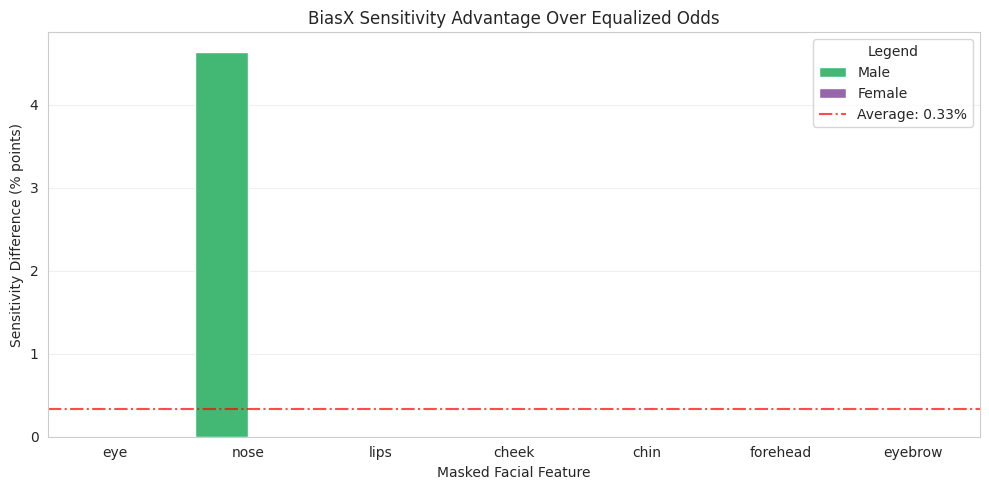

In [7]:
def plot_sensitivity_difference():
    """Plots the sensitivity advantage of BiasX over Equalized Odds."""
    with open(FEATURE_MASK_DATAPATH, "r") as file:
        experiment_results = json.load(file)

    result_df = prepare_ablation_data(experiment_results)

    plt.figure(figsize=(10, 5))

    ax = sns.barplot(data=result_df, x="feature", y="sensitivity_diff", hue="masked_gender", palette=["#2ecc71", "#9b59b6"])

    avg_sensitivity = result_df["sensitivity_diff"].mean()
    ax.axhline(y=avg_sensitivity, color="red", linestyle="-.", alpha=0.7, label=f"Average: {avg_sensitivity:.2f}%")

    ax.set_title("BiasX Sensitivity Advantage Over Equalized Odds")
    ax.set_xlabel("Masked Facial Feature")
    ax.set_ylabel("Sensitivity Difference (% points)")
    ax.legend(title="Legend")
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_sensitivity_difference()